# <code style="background:white;color:#85C1E9,">Analysis of emotion detection on faces using Convolutional Neural Networks</code>


## <code style="background:#154360;color:white">1. Introduction</code>


Emotions are a key aspect of the human experience and communication. Understanding emotions deeply influences human life, including social interactions, decision-making, and psychological well-being. In the era of digital technology, the ability of computers to recognize and interpret emotions is becoming increasingly important, opening doors to a wide range of applications. This encompasses various areas, from personalized user experiences in e-commerce to advanced systems for automatic real-time recognition and interpretation of human emotions.

This project explores the application of Convolutional Neural Networks (CNNs) in combination with advanced optimization algorithms for precise emotion detection on human faces in content provided in images. This research aims to overcome challenges in recognizing and classifying facial emotional expressions, providing a deeper understanding of how deep learning and optimization approaches can enhance the accuracy and efficiency of this process.

### <code style="background:#85C1E9; color:white">1.1 Import Python libraries</code>



In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dropout, Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img  # Updated import
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output

### <code style="background:#85C1E9; color:white">1.2 Load the dataset</code>


In [2]:
train_dir = "./FER/train"
test_dir = "./FER/test"

For the partitioning of the dataset, we use a three-way split, i.e., we have divided the dataset into training set, test set, and validation set.

1. The *<code style="color:#154360">training set</code>* is used to train the model. The model adapts to the training data to learn how to recognize emotions on faces in line with the specified goal.

2. The *<code style="color:#154360">validation set</code>* is employed during the training process to monitor the model's performance on an independent dataset. This allows for experimentation with hyperparameters and early detection of overfitting issues in the network.

3. The *<code style="color:#154360">test set</code>* serves as the final evaluation of the model after the training is complete. The model is tested on this set to assess its accuracy under real-world conditions.

### <code style="background:#154360;color:white">2. Exploratory Data Analysis</code>

Using the *<code style="color:#154360">'ImageDataGenerator'</code>* class , we enable the generation of new images by applying various transformations to the original images, employing augmentation. **Augmentation** is a technique used in deep learning to enrich training datasets so that the model has better generalization and the ability to handle various variations of images. These methods have been applied to all three datasets.

In [3]:
# Define data augmentation for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Define data preprocessing for the testing dataset
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

# Generate batches of augmented training data
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(48, 48),
    batch_size=128,
    color_mode="rgb",
    class_mode="categorical",
    subset="training",
    seed=12
)

# Generate batches of testing data
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(48, 48),
    batch_size=128,
    color_mode="rgb",
    class_mode="categorical",
    seed=12
)

# Generate batches of validation data 
validation_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(48, 48),
    batch_size=128,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    seed=12
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


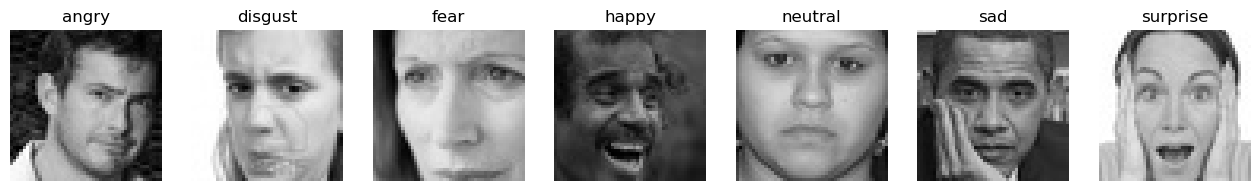

In [4]:
# Displaying images with different emotions.
plt.figure(figsize=(16, 16))
i = 1
for expression in os.listdir(train_dir):
    img_path = os.path.join(train_dir, expression, os.listdir(os.path.join(train_dir, expression))[1])
    img = load_img(img_path)
    plt.subplot(1, 7, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

The dataset comprises 35,685 examples of facial images with dimensions of 48x48 pixels, divided into a training set and a test set. The images are categorized based on the emotions depicted in facial expressions (happiness, neutrality, sadness, anger, surprise, disgust, fear). Each image is labeled with the corresponding emotion, which is crucial for the development of emotion recognition models.

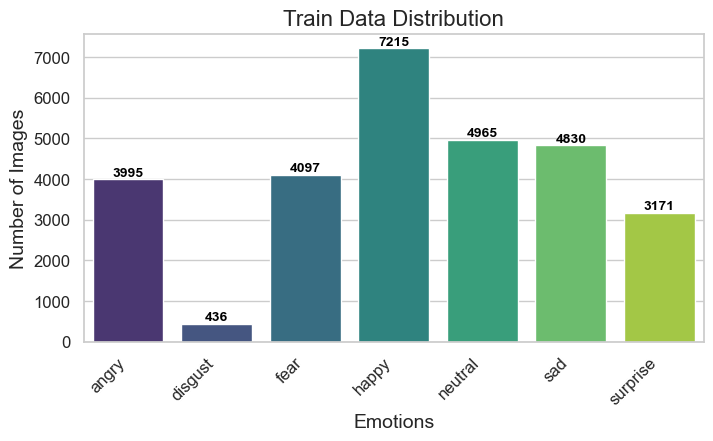

In [5]:
class_counts = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)]
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Set the seaborn style
sns.set(style="whitegrid", palette="pastel")

# Create a bar plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x=class_names, y=class_counts, palette="viridis")  # Adjust the palette as needed

# Add count annotations on top of the bars
for i, count in enumerate(class_counts):
    ax.text(i, count + 10, str(count), ha='center', va='bottom', fontweight='bold', color='black', size=10)

# Customize the plot
plt.xlabel('Emotions', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Train Data Distribution', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### <code style="background:#154360;color:white">3. CNN Architectures</code>

### <code style="background:#85C1E9; color:white">3.1 DenseNet121</code>


"DenseNet-121" is a neural network architecture that we use to address our problem. This architecture is part of the "DenseNet" (Densely Connected Convolutional Networks) family, known for its densely connected layers, which is the main characteristic of this architecture. An example of the architecture is shown in the figure below.

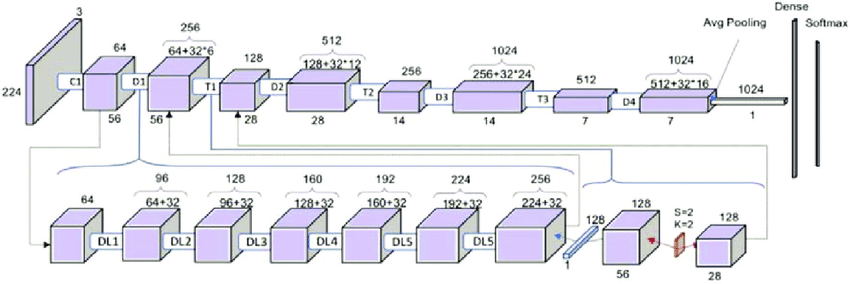

In [6]:
SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 128
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA = 3
CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

The provided code defines a Convolutional Neural Network (CNN) using the DenseNet121 architecture for image classification. It consists of three main functions: *<code style="color:#154360">'feature_extractor'</code>*, which creates the DenseNet121 feature extraction layer; *<code style="color:#154360">'classifier'</code>*, responsible for building the classification head; and *<code style="color:#154360">'final_model'</code>*, combining the feature extractor and classifier. The overall model is compiled using stochastic gradient descent (SGD) as the optimizer, categorical crossentropy as the loss function, and accuracy as the evaluation metric. The model is designed to take input images of size (48, 48, 3) and outputs class probabilities for a specified number of classes (denoted as NUM_CLASSES).

In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(
        input_shape=(48, 48, 3),
        include_top=False,
        weights="imagenet")(inputs)

    return feature_extractor

In [18]:
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

In [19]:
def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

In [20]:
def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(48, 48, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(
        optimizer=tf.keras.optimizers.SGD(0.1),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

Model Compilation and Freezing Layers:

1. *<code style="color:#154360">define_compile_model()</code>*
This function is used to create a model and compile it with SGD optimizer, categorical crossentropy loss, and accuracy as the metric.
The feature extraction layers of the model (DenseNet121) are frozen by setting model.layers[1].trainable to False.
The model summary is printed.
Training with Early Stopping:

2. The model
is trained on the training data (train_generator) for 30 epochs with validation on validation_generator.
An EarlyStopping callback is employed to stop training if the validation loss does not improve after a certain patience (EARLY_STOPPING_CRITERIA) and restore the weights to the best performing ones.
Fine-Tuning:

3. The frozen layers are unfrozen (model.layers[1].trainable = True) to allow fine-tuning.
4. The model is recompiled with a lower learning rate (0.001) and momentum (0.9) for fine-tuning.
5. The model is trained again for a specified number of epochs (FINE_TUNING_EPOCHS) with early stopping. The training history is stored in the history_ variable.

In [ ]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOPPING_CRITERIA,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    x=train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[earlyStoppingCallback]
)

history = pd.DataFrame(history.history)

model.layers[1].trainable = True

model.compile(
    optimizer=tf.keras.optimizers.SGD(0.001, 0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ = model.fit(
    x=train_generator,
    epochs=FINE_TUNING_EPOCHS,
    validation_data=validation_generator,
    callbacks=[earlyStoppingCallback],
)


x = px.line(data_frame=history, y=["accuracy", "val_accuracy"], markers=True)
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title="Accuracy")
x.update_layout(
    showlegend=True,
    title={
        'text': 'Accuracy vs Number of Epochs',
        'y': 0.94,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

x = px.line(data_frame=history, y=["loss", "val_loss"], markers=True)
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title="Loss")
x.update_layout(
    showlegend=True,
    title={
        'text': 'Loss vs Number of Epochs',
        'y': 0.94,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

This section of code evaluates the performance of a model on a test dataset and provides a comprehensive analysis of the classification results:

Evaluation:

1. The model.evaluate(test_generator) method assesses the model's performance on the test dataset.
The predictions (preds) are obtained using the alexnet_model.predict(test_generator) method.
Classification Report and Confusion Matrix:

2. The scikit-learn classification_report is used to generate a detailed classification report, including precision, recall, and F1-score for each class.
The confusion matrix is computed using the confusion_matrix function and visualized using Seaborn's heatmap.
Receiver Operating Characteristic (ROC) Curve:

3. The code defines a function multiclass_roc_auc_score to compute and visualize ROC curves for each class, displaying the area under the curve (AUC) for each.
The overall micro-average ROC AUC score is calculated and printed.
Visualization:

4. Heatmaps are used to display the confusion matrix, providing insights into the model's performance across different classes.
ROC curves are plotted to visualize the trade-off between true positive rate and false positive rate for each class.

In [ ]:
model.evaluate(test_generator)
preds = alexnet_model.predict(test_generator)
y_preds = np.argmax(preds, axis=1)
y_test = np.array(test_generator.labels)

print(classification_report(y_test, y_preds))

In [ ]:
cm_data = confusion_matrix(y_test, y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

plt.figure(figsize=(20, 10))
plt.title('Confusion Matrix', fontsize=20)
sb.set(font_scale=1.2)
ax = sb.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:, idx].astype(int), y_pred[:, idx])
        c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black', linestyle='dashed', lw=4, label='Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test, preds, average="micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

### <code style="background:#85C1E9;color:white">3.1 AlexNet</code>


"AlexNet" is an architecture that gained significant popularity after achieving outstanding results in the 2012 ImageNet Large Scale Visual Recognition Challenge. These results were obtained by using the ReLU activation function, along with mitigating the risk of the vanishing gradient problem.

In Figure below, we can see that the model consists of a total of 8 layers: 5 layers with a combination of max-pooling, followed by 3 fully connected layers. It is the first type of architecture that introduced consecutive convolutional layers.

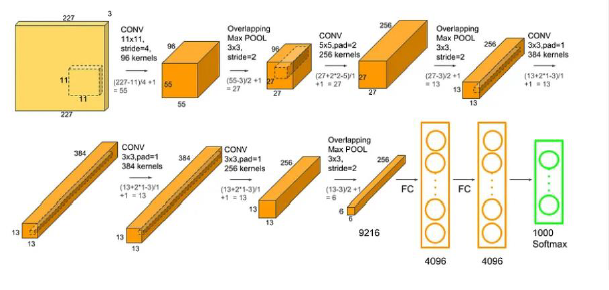

Structure of convolutional layers:

Conv2D: A function that uses small filters (matrices) moving across images and performs a mathematical operation called convolution. This operation allows the network to learn different features of images, such as edges, shapes, and textures.

MaxPooling: Max pooling is a layer in CNN used to reduce dimensionality and the number of parameters. It does so by dividing the image into smaller regions and returning the maximum value for each region. This helps preserve the essential features of the image and reduces computational load.

BatchNormalization: Batch normalization is a technique used to normalize the outputs of layers in a neural network. This helps accelerate training and improve network stability. Normalization scales the output layers to have a mean close to zero and a standard deviation close to one.

Dropout: A regularization technique used during training. The idea is to randomly deactivate certain neurons during each pass through the network. This helps prevent overfitting by forcing the network not to rely too much on specific neurons, thus achieving better generalization.

In [ ]:
input_layer = Input(shape=(48, 48, 3))

# First convolutional layer
x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(input_layer)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)
x = BatchNormalization()(x)

# Second convolutional layer
x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)

# Third convolutional layer
x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)
x = BatchNormalization()(x)

# Fourth convolutional layer
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)
x = BatchNormalization()(x)

# Fifth convolutional layer
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)
x = BatchNormalization()(x)

# Fully connected layer
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation='softmax')(x)

In [ ]:
#Creating model
alexnet_model = Model(inputs=input_layer, outputs=output_layer)

alexnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

alexnet_model.summary()

This code snippet demonstrates the training process for an AlexNet model on an image classification task with a two-phase approach: initial training and fine-tuning.

Early Stopping Initialization:

1. An EarlyStopping callback is defined to monitor the validation loss during training, with patience set to EARLY_STOPPING_CRITERIA. This callback restores the model's best weights when triggered.
Initial Training Phase:

2. The AlexNet model is trained for 20 epochs on the training dataset (train_generator) with validation on the validation dataset (validation_generator).
Early stopping is employed to prevent overfitting and ensure the best model performance.
Freezing and Fine-Tuning:

3. After the initial training, the code unfreezes the trainable layers of the AlexNet model (alexnet_model.layers[1].trainable = True).
The model is recompiled with the Adam optimizer and a learning rate of 0.01.
Fine-tuning is performed for a specified number of epochs (FINE_TUNING_EPOCHS) on the training and validation datasets with early stopping to further refine the model's performance.

In [ ]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOPPING_CRITERIA,
    verbose=1,
    restore_best_weights=True
)

history = alexnet_model.fit(
    x=train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[earlyStoppingCallback]
)

history = pd.DataFrame(history.history)

alexnet_model.layers[1].trainable = True

alexnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ = alexnet_model.fit(
    x=train_generator,
    epochs=FINE_TUNING_EPOCHS,
    validation_data=validation_generator,
    callbacks=[earlyStoppingCallback],
)

# history = history.append(pd.DataFrame(history_.history), ignore_index=True)

x = px.line(data_frame=history, y=["accuracy", "val_accuracy"], markers=True)
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title="Accuracy")
x.update_layout(
    showlegend=True,
    title={
        'text': 'Accuracy vs Number of Epochs',
        'y': 0.94,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

x = px.line(data_frame=history, y=["loss", "val_loss"], markers=True)
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title="Loss")
x.update_layout(
    showlegend=True,
    title={
        'text': 'Loss vs Number of Epochs',
        'y': 0.94,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

This section of code evaluates the performance of a model on a test dataset and provides a comprehensive analysis of the classification results:

Evaluation:

1. The model.evaluate(test_generator) method assesses the model's performance on the test dataset.
The predictions (preds) are obtained using the alexnet_model.predict(test_generator) method.
Classification Report and Confusion Matrix:

2. The scikit-learn classification_report is used to generate a detailed classification report, including precision, recall, and F1-score for each class.
The confusion matrix is computed using the confusion_matrix function and visualized using Seaborn's heatmap.
Receiver Operating Characteristic (ROC) Curve:

3. The code defines a function multiclass_roc_auc_score to compute and visualize ROC curves for each class, displaying the area under the curve (AUC) for each.
The overall micro-average ROC AUC score is calculated and printed.
Visualization:

4. Heatmaps are used to display the confusion matrix, providing insights into the model's performance across different classes.
ROC curves are plotted to visualize the trade-off between true positive rate and false positive rate for each class.

In [ ]:
alexnet_model.evaluate(test_generator)
preds = alexnet_model.predict(test_generator)
y_preds = np.argmax(preds, axis=1)
y_test = np.array(test_generator.labels)

print(classification_report(y_test, y_preds))

In [ ]:
cm_data = confusion_matrix(y_test, y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

plt.figure(figsize=(20, 10))
plt.title('Confusion Matrix', fontsize=20)
sb.set(font_scale=1.2)
ax = sb.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:, idx].astype(int), y_pred[:, idx])
        c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black', linestyle='dashed', lw=4, label='Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test, preds, average="micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

### <code style="background:#154360;color:white">4. Conclusion</code>

The conclusion of this research on the application of CNN for emotion classification on human faces yields several important insights. Firstly, the study demonstrates that achieving high accuracy in emotion classification on facial images is possible with the use of deep neural networks. Utilizing the 'AlexNet' and 'DenseNet-121' models, after appropriate hyperparameter tuning, has enabled the attainment of precise results.

'DenseNet-121', with its deep structure and the ability for good generalization, can be an excellent choice for tasks involving extensive datasets and where accuracy is crucial. The depth allows this model to learn complex patterns in the data. However, 'AlexNet' proves to be more resource-efficient and faster in execution, making it a preferable choice for applications with limited resources, such as devices with less processing power or restricted RAM. Although it excels in the speed of analysis, it may be less adept at generalizing in complex tasks due to its shallower architecture.

The primary purpose of this research is to determine which of these two models may be a better choice for a specific application. Based on the presented results and analysis, we conclude that the 'DenseNet-121' architecture is a better choice because high precision is crucial in our task, although both models have demonstrated their advantages and disadvantages.

It is important to note that there is still room for improvement and further exploration. Additional experiments and analyses may allow for further optimizations and potential customization of both models for specific applications. The potential and future research will be directed towards implementing an application that can successfully detect emotions in real-time. This step can be particularly useful for a wide range of applications, such as monitoring emotions during video conferences, analyzing audience reactions at events, or user interactions in virtual reality applications.